In [119]:
from datasets import load_dataset
from transformers import BertTokenizerFast
import torch
from torch.utils.data import DataLoader

# Load the dataset and select only the first 1000 entries
dataset = load_dataset("roneneldan/TinyStories", split="train[:10000]")

# Initialize BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

# Add special tokens and resize tokenizer vocabulary
special_tokens_dict = {'additional_special_tokens': ['[NL]']}
tokenizer.add_special_tokens(special_tokens_dict)

# Retrieve and print token IDs to verify
nl_token_id = tokenizer.convert_tokens_to_ids('[NL]')
pad_token_id = tokenizer.pad_token_id  # Already defined in BERT tokenizer as [PAD]

# Verify dataset length to ensure it's limited to 1000
print(f"Loaded dataset length: {len(dataset)}")

Loaded dataset length: 10000


In [120]:
filtered_data = []

for entry in dataset:
    text = entry['text']
    # Tokenize without truncation to get the full length
    encodings = tokenizer(text, truncation=False, return_tensors="pt")
    token_count = encodings['input_ids'].shape[1]  # Number of tokens in this sequence
    # Append only if token count is within the 511 token limit
    if token_count <= 295:
        filtered_data.append(entry)
len(filtered_data)

Token indices sequence length is longer than the specified maximum sequence length for this model (950 > 512). Running this sequence through the model will result in indexing errors


8972

In [121]:
import pandas as pd
df = pd.DataFrame(filtered_data)
df['text'] = df['text'].str.lower()
df


,text
0,"one day, a little girl named lily found a need..."
1,"once upon a time, there was a little car named..."
2,"one day, a little fish named fin was swimming ..."
3,"once upon a time, in a land full of trees, the..."
4,"once upon a time, there was a little girl name..."
...,...
8967,"once upon a time, there was a graceful armchai..."
8968,once there was a happy lady who loved carrying...
8969,"once there was a little girl, maria, who was v..."
8970,"one day, two sisters anna and bella were playi..."


In [95]:
df['Tokenized'] = df['text'].apply(
    lambda x: tokenizer.encode(x, truncation=True, max_length=300, add_special_tokens=False)
)

# Display the DataFrame
print(df.head())

                                                text  \
0  one day, a little girl named lily found a need...   
1  once upon a time, there was a little car named...   
2  one day, a little fish named fin was swimming ...   
3  once upon a time, in a land full of trees, the...   
4  once upon a time, there was a little girl name...   

                                           Tokenized  
0  [2028, 2154, 1010, 1037, 2210, 2611, 2315, 709...  
1  [2320, 2588, 1037, 2051, 1010, 2045, 2001, 103...  
2  [2028, 2154, 1010, 1037, 2210, 3869, 2315, 103...  
3  [2320, 2588, 1037, 2051, 1010, 1999, 1037, 245...  
4  [2320, 2588, 1037, 2051, 1010, 2045, 2001, 103...  


In [96]:
df["token_length"] = df["Tokenized"].apply(len)

df_sorted = df.sort_values(by="token_length")

# Reset the index for the sorted DataFrame
df_sorted.reset_index(drop=True, inplace=True)

In [97]:
def create_target(tokens):
    total_tokens = len(tokens)
    # Calculate the 75% index
    split_index = int(total_tokens * 0.75)
    
    # Create target by replacing first 75% tokens with pad (token id 0 is [PAD])
    target_tokens = [0] * split_index + tokens[split_index:]
    return target_tokens

def create_target_text(tokens):
    total_tokens = len(tokens)
    # Calculate the 75% index
    split_index = int(total_tokens * 0.75)
    
    # Create target by replacing first 75% tokens with pad (token id 0 is [PAD])
    target_tokens = tokens[split_index:]
    return tokenizer.decode(target_tokens)

# Create the target column
df['Target_Text'] = df['Tokenized'].apply(create_target_text)
df['Target'] = df['Tokenized'].apply(create_target)

# Display the DataFrame with tokenized and target columns
print(df.head(-1))

                                                 text  \
0   one day, a little girl named lily found a need...   
1   once upon a time, there was a little car named...   
2   one day, a little fish named fin was swimming ...   
3   once upon a time, in a land full of trees, the...   
4   once upon a time, there was a little girl name...   
..                                                ...   
94  once upon a time there lived a little girl nam...   
95  once upon a time, there was a little girl name...   
96  once upon a time, there was a creative farmer ...   
97  once upon a time a little girl named jill had ...   
98  once upon a time, there was a small girl named...   

                                            Tokenized  token_length  \
0   [2028, 2154, 1010, 1037, 2210, 2611, 2315, 709...           162   
1   [2320, 2588, 1037, 2051, 1010, 2045, 2001, 103...           172   
2   [2028, 2154, 1010, 1037, 2210, 3869, 2315, 103...           215   
3   [2320, 2588, 1037, 2051, 10

In [ ]:
'''df['Source'] = df['Tokenized'].apply(lambda tokens: [tokenizer.cls_token_id] + tokens)

# Add SEP token (102) at the end for the 'target' column
df['Target'] = df['Tokenized'].apply(lambda tokens: tokens + [tokenizer.sep_token_id])

# Display the DataFrame
print(df.head())'''

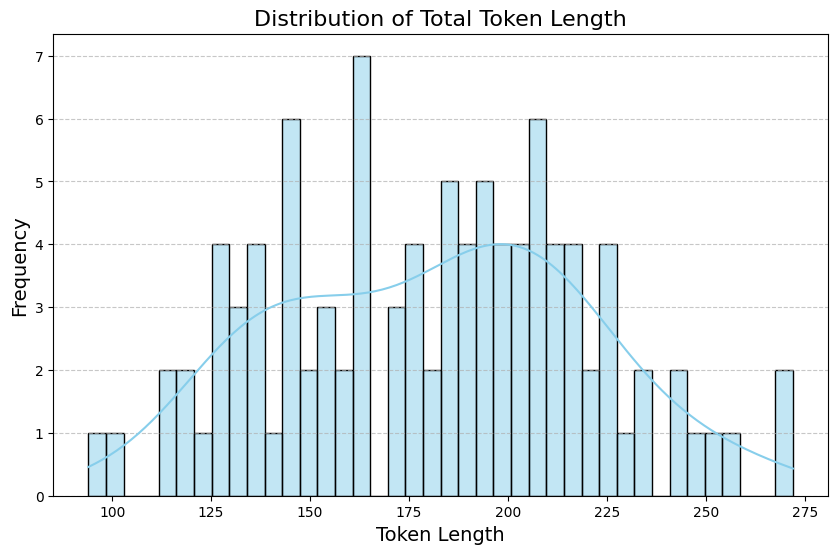

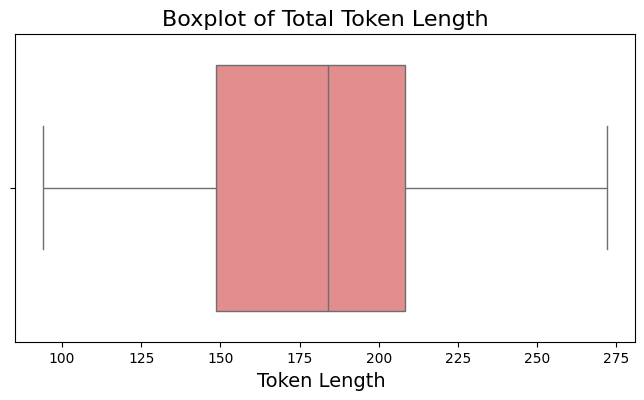

In [98]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution of total token length using a histogram
plt.figure(figsize=(10, 6))
sns.histplot(df_sorted["token_length"], bins=40, kde=True, color="skyblue")
plt.title("Distribution of Total Token Length", fontsize=16)
plt.xlabel("Token Length", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# Optional: Boxplot for a quick summary of the distribution
plt.figure(figsize=(8, 4))
sns.boxplot(x=df_sorted["token_length"], color="lightcoral")
plt.title("Boxplot of Total Token Length", fontsize=16)
plt.xlabel("Token Length ", fontsize=14)
plt.show()

In [99]:
import numpy as np

# Example of the maximum padding length
max_len = 300
cls_token = tokenizer.cls_token_id
sep_token = tokenizer.sep_token_id

# Function to pad sequences
def pad_sequence_source(tokens, max_len, cls_token = tokenizer.cls_token):
    # Add the cls token at the beginning
    padded_tokens = [cls_token] + tokens  

    # Pad the sequence if it's shorter than max_len
    if len(padded_tokens) < max_len:
        padded_tokens.extend([0] * (max_len - len(padded_tokens)))
    # Truncate if it's longer than max_len
    else:
        print("some problem in padding source ,token length", len(padded_tokens), max_len)
        padded_tokens = padded_tokens[:max_len]

    return padded_tokens

def pad_sequence_target(tokens, max_len, sep_token = tokenizer.sep_token):
    # Add the cls token at the beginning
    padded_tokens = tokens + [sep_token]

    # Pad the sequence if it's shorter than max_len
    if len(padded_tokens) < max_len:
        padded_tokens.extend([0] * (max_len - len(padded_tokens)))
    # Truncate if it's longer than max_len
    else:
        print("some problem in padding target ,token length", len(padded_tokens) , max_len )
        padded_tokens = padded_tokens[:max_len]

    return padded_tokens

# Apply padding and add CLS token to both English and Tamil columns
df['Padded_source'] = df['Tokenized'].apply(lambda x: pad_sequence_source(x, max_len, cls_token,))
df['Padded_target'] = df['Target'].apply(lambda x: pad_sequence_target(x, max_len, sep_token))

# Verify the result
#print(df[['Padded_English', 'Padded_Tamil','Padded_Tamil_Target']].head(-10))
df

,text,Tokenized,token_length,Target_Text,Target,Padded_source,Padded_target
0,"one day, a little girl named lily found a need...","[2028, 2154, 1010, 1037, 2210, 2611, 2315, 709...",162,difficult for them because they were sharing a...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[101, 2028, 2154, 1010, 1037, 2210, 2611, 2315...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,"once upon a time, there was a little car named...","[2320, 2588, 1037, 2051, 1010, 2045, 2001, 103...",172,##p knew he needed more fuel. he went to the f...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[101, 2320, 2588, 1037, 2051, 1010, 2045, 2001...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,"one day, a little fish named fin was swimming ...","[2028, 2154, 1010, 1037, 2210, 3869, 2315, 103...",215,"not so cold. he saw fin and said, "" thank you,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[101, 2028, 2154, 1010, 1037, 2210, 3869, 2315...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"once upon a time, in a land full of trees, the...","[2320, 2588, 1037, 2051, 1010, 1999, 1037, 245...",190,the land came to eat the cherries and play und...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[101, 2320, 2588, 1037, 2051, 1010, 1999, 1037...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,"once upon a time, there was a little girl name...","[2320, 2588, 1037, 2051, 1010, 2045, 2001, 103...",162,"sad, but it found a new home outside. lily, th...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[101, 2320, 2588, 1037, 2051, 1010, 2045, 2001...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...
95,"once upon a time, there was a little girl name...","[2320, 2588, 1037, 2051, 1010, 2045, 2001, 103...",198,to her mother. lola showed her mom the pastry ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[101, 2320, 2588, 1037, 2051, 1010, 2045, 2001...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
96,"once upon a time, there was a creative farmer ...","[2320, 2588, 1037, 2051, 1010, 2045, 2001, 103...",222,the hill and across the field until they reach...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[101, 2320, 2588, 1037, 2051, 1010, 2045, 2001...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
97,once upon a time a little girl named jill had ...,"[2320, 2588, 1037, 2051, 1037, 2210, 2611, 231...",225,toy robot! she was so excited and couldn ' t b...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[101, 2320, 2588, 1037, 2051, 1037, 2210, 2611...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
98,"once upon a time, there was a small girl named...","[2320, 2588, 1037, 2051, 1010, 2045, 2001, 103...",272,"their way. susie and the kitty were scared, bu...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[101, 2320, 2588, 1037, 2051, 1010, 2045, 2001...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [100]:
df['Greedy'] = df['Tokenized'].apply(lambda tokens: [tokenizer.cls_token_id] + tokens[:int(len(tokens)*0.75)] )
df

,text,Tokenized,token_length,Target_Text,Target,Padded_source,Padded_target,Greedy
0,"one day, a little girl named lily found a need...","[2028, 2154, 1010, 1037, 2210, 2611, 2315, 709...",162,difficult for them because they were sharing a...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[101, 2028, 2154, 1010, 1037, 2210, 2611, 2315...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[101, 2028, 2154, 1010, 1037, 2210, 2611, 2315..."
1,"once upon a time, there was a little car named...","[2320, 2588, 1037, 2051, 1010, 2045, 2001, 103...",172,##p knew he needed more fuel. he went to the f...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[101, 2320, 2588, 1037, 2051, 1010, 2045, 2001...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[101, 2320, 2588, 1037, 2051, 1010, 2045, 2001..."
2,"one day, a little fish named fin was swimming ...","[2028, 2154, 1010, 1037, 2210, 3869, 2315, 103...",215,"not so cold. he saw fin and said, "" thank you,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[101, 2028, 2154, 1010, 1037, 2210, 3869, 2315...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[101, 2028, 2154, 1010, 1037, 2210, 3869, 2315..."
3,"once upon a time, in a land full of trees, the...","[2320, 2588, 1037, 2051, 1010, 1999, 1037, 245...",190,the land came to eat the cherries and play und...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[101, 2320, 2588, 1037, 2051, 1010, 1999, 1037...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[101, 2320, 2588, 1037, 2051, 1010, 1999, 1037..."
4,"once upon a time, there was a little girl name...","[2320, 2588, 1037, 2051, 1010, 2045, 2001, 103...",162,"sad, but it found a new home outside. lily, th...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[101, 2320, 2588, 1037, 2051, 1010, 2045, 2001...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[101, 2320, 2588, 1037, 2051, 1010, 2045, 2001..."
...,...,...,...,...,...,...,...,...
95,"once upon a time, there was a little girl name...","[2320, 2588, 1037, 2051, 1010, 2045, 2001, 103...",198,to her mother. lola showed her mom the pastry ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[101, 2320, 2588, 1037, 2051, 1010, 2045, 2001...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[101, 2320, 2588, 1037, 2051, 1010, 2045, 2001..."
96,"once upon a time, there was a creative farmer ...","[2320, 2588, 1037, 2051, 1010, 2045, 2001, 103...",222,the hill and across the field until they reach...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[101, 2320, 2588, 1037, 2051, 1010, 2045, 2001...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[101, 2320, 2588, 1037, 2051, 1010, 2045, 2001..."
97,once upon a time a little girl named jill had ...,"[2320, 2588, 1037, 2051, 1037, 2210, 2611, 231...",225,toy robot! she was so excited and couldn ' t b...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[101, 2320, 2588, 1037, 2051, 1037, 2210, 2611...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[101, 2320, 2588, 1037, 2051, 1037, 2210, 2611..."
98,"once upon a time, there was a small girl named...","[2320, 2588, 1037, 2051, 1010, 2045, 2001, 103...",272,"their way. susie and the kitty were scared, bu...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[101, 2320, 2588, 1037, 2051, 1010, 2045, 2001...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[101, 2320, 2588, 1037, 2051, 1010, 2045, 2001..."


In [104]:
j = 0
for i in df['Greedy']:
    if len(i) != 182:
        j += 1
j

99

In [105]:
import torch
from torch.utils.data import Dataset

class TranslationDataset(Dataset):
    def __init__(self, dataframe, pad_token=0):
        self.dataframe = dataframe
        self.pad_token = pad_token  # Padding value, typically 0

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # Get the tokenized sequences for English and Tamil
        source =  self.dataframe.iloc[idx]["text"]
        target_text =  self.dataframe.iloc[idx]["Target_Text"]
        source_tokens =  torch.tensor(self.dataframe.iloc[idx]["Padded_source"],  dtype=torch.long) 
        target_tokens = torch.tensor(self.dataframe.iloc[idx]["Padded_target"],  dtype=torch.long)   

        def causal_mask(size):
              mask = torch.triu(torch.ones((1, size, size)), diagonal=1).type(torch.int)
              return mask == 0
    # Return the sequence and masks in a dictionary
        return {
            "source": source,
            "target_text": target_text,
            "source_tokens": source_tokens.clone(),
            "target_tokens": target_tokens.clone(),
            "decoder_mask": (target_tokens != self.pad_token).unsqueeze(0).int() & causal_mask(target_tokens.size(0)).clone(),

        }

In [106]:
import torch
from torch.utils.data import Dataset

class TranslationDataset_test(Dataset):
    def __init__(self, dataframe, pad_token=0):
        self.dataframe = dataframe
        self.pad_token = pad_token  # Padding value, typically 0

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # Get the tokenized sequences for English and Tamil
        source =  self.dataframe.iloc[idx]["text"]
        target_text =  self.dataframe.iloc[idx]["Target_Text"]
        greedy =  self.dataframe.iloc[idx]["Greedy"]
        source_tokens =  torch.tensor(self.dataframe.iloc[idx]["Padded_source"],  dtype=torch.long) 
        target_tokens = torch.tensor(self.dataframe.iloc[idx]["Padded_target"],  dtype=torch.long)   

        def causal_mask(size):
              mask = torch.triu(torch.ones((1, size, size)), diagonal=1).type(torch.int)
              return mask == 0
    # Return the sequence and masks in a dictionary
        return {
            "source": source,
            "target_text": target_text,
            "greedy": greedy,
            "source_tokens": source_tokens.clone(),
            "target_tokens": target_tokens.clone(),
            "decoder_mask": (target_tokens != self.pad_token).unsqueeze(0).int() & causal_mask(target_tokens.size(0)).clone(),

        }

In [107]:
from torch.utils.data import DataLoader

# Assuming you have your Dataset class `TranslationDataset` and DataLoader defined
# Example DataLoader for your dataset
'''dataset1 = TranslationDataset(level1)  # Your dataframe should be defined
train_dataloader_1 = DataLoader(dataset1, batch_size = 32, shuffle=True)  # Set batch_size as needed  # Your dataframe should be defined
test_dataloader_1 = DataLoader(dataset1, batch_size=1, shuffle=True)  # Set batch_size as needed

dataset2 = TranslationDataset(level2)  # Your dataframe should be defined
train_dataloader_2 = DataLoader(dataset2, batch_size = 32, shuffle=True)  # Set batch_size as needed  # Your dataframe should be defined
test_dataloader_2 = DataLoader(dataset2, batch_size=1, shuffle=True)  # Set batch_size as needed

dataset3 = TranslationDataset(level3)  # Your dataframe should be defined
train_dataloader_3 = DataLoader(dataset3, batch_size = 32, shuffle=True)  # Set batch_size as needed  # Your dataframe should be defined
test_dataloader_3 = DataLoader(dataset3, batch_size=1, shuffle=True)  # Set batch_size as needed'''

dataset4 = TranslationDataset(df)  # Your dataframe should be defined
train_dataloader_4 = DataLoader(dataset4, batch_size = 32, shuffle=False)  # Set batch_size as needed  # Your dataframe should be defined
# Iterate through batches

for batch_idx, batch in enumerate(train_dataloader_4):
    print(f"Batch {batch_idx + 1}:")

    # Check the shapes of each tensor in the batch
    print(f"  text sequence shape: {batch['source'][0]}")  # Expected: (batch_size, T_english)
    print(f"  target text sequence shape: {batch['target_text'][0]}")  # Expected: (batch_size, T_english)
    print(f"  source_tokens sequence shape: {batch['source_tokens'].shape}")  # Expected: (batch_size, T_tamil)
    print(f"  target_tokens token shape: {batch['target_tokens'].shape}")  # Expected: (batch_size, T_english)
    print(f"  Combined Tamil mask shape: {batch['decoder_mask'].shape}")  # Expected: (batch_size, T_tamil_target, T_tamil_target)
    break
    

dataset_test = TranslationDataset_test(df)
test_dataloader_4 = DataLoader(dataset_test, batch_size=1, shuffle=True)  # Set batch_size as needed
# Iterate through batches
for batch_idx, batch in enumerate(test_dataloader_4):
    print(f"Batch {batch_idx + 1}:")

   
    # Check the shapes of each tensor in the batch
    print(f"  text sequence shape: {torch.tensor(tokenizer.encode(batch['source'][0])).shape}")  # Expected: (batch_size, T_english)
    print(f"  target text sequence shape: {batch['target_text'][0]}")  # Expected: (batch_size, T_english)
    print(f"  source_tokens sequence shape: {batch['source_tokens'].shape}")  # Expected: (batch_size, T_tamil)
    print(f"  greedy_tokens token shape: {torch.cat(batch['greedy']).shape}")  # Expected: (batch_size, T_english)
    print(f"  target_tokens token shape: {batch['target_tokens'].shape}")  # Expected: (batch_size, T_english)
    print(f"  Combined Tamil mask shape: {batch['decoder_mask'].shape}")  # Expected: (batch_size, T_tamil_target, T_tamil_target)
    break


Batch 1:
  text sequence shape: one day, a little girl named lily found a needle in her room. she knew it was difficult to play with it because it was sharp. lily wanted to share the needle with her mom, so she could sew a button on her shirt.

lily went to her mom and said, "mom, i found this needle. can you share it with me and sew my shirt?" her mom smiled and said, "yes, lily, we can share the needle and fix your shirt."

together, they shared the needle and sewed the button on lily's shirt. it was not difficult for them because they were sharing and helping each other. after they finished, lily thanked her mom for sharing the needle and fixing her shirt. they both felt happy because they had shared and worked together.
  target text sequence shape: difficult for them because they were sharing and helping each other. after they finished, lily thanked her mom for sharing the needle and fixing her shirt. they both felt happy because they had shared and worked together.
  source_token

In [108]:
tokenizer.vocab_size + len(tokenizer.added_tokens_encoder)

30528

In [109]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


tgt_vocab_size = tokenizer.vocab_size + len(tokenizer.added_tokens_encoder)
d_model = 64
n_heads = 8
d_ff = 512
n_dec_layers = 8
dropout = 0.1

import torch
import torch.nn as nn
import math
import torch.nn.functional as F

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

class MultiHeadSelfAttention(nn.Module):

    def __init__(self, d_model: int, h: int, dropout: float) -> None:
        super().__init__()
        self.d_model = d_model # Embedding vector size
        self.h = h # Number of heads
        # Make sure d_model is divisible by h
        assert d_model % h == 0, "d_model is not divisible by h"

        self.d_k = d_model // h # Dimension of vector seen by each head
        self.w_q = nn.Linear(d_model, d_model, bias=False) # Wq
        self.w_k = nn.Linear(d_model, d_model, bias=False) # Wk
        self.w_v = nn.Linear(d_model, d_model, bias=False) # Wv
        self.w_o = nn.Linear(d_model, d_model, bias=False) # Wo
        self.dropout = nn.Dropout(dropout)

    @staticmethod
    def attention(query, key, value, mask, dropout: nn.Dropout):
        d_k = query.shape[-1]
        # Just apply the formula from the paper
        # (batch, h, seq_len, d_k) --> (batch, h, seq_len, seq_len)
        attention_scores = (query @ key.transpose(-2, -1)) / math.sqrt(d_k)
        if mask is not None:
            # Write a very low value (indicating -inf) to the positions where mask == 0
            attention_scores.masked_fill_(mask == 0, -1e9)
        attention_scores = attention_scores.softmax(dim=-1) # (batch, h, seq_len, seq_len) # Apply softmax
        if dropout is not None:
            attention_scores = dropout(attention_scores)
        # (batch, h, seq_len, seq_len) --> (batch, h, seq_len, d_k)
        # return attention scores which can be used for visualization
        return (attention_scores @ value), attention_scores

    def forward(self, q, k, v, mask):
        query = self.w_q(q) # (batch, seq_len, d_model) --> (batch, seq_len, d_model)
        key = self.w_k(k) # (batch, seq_len, d_model) --> (batch, seq_len, d_model)
        value = self.w_v(v) # (batch, seq_len, d_model) --> (batch, seq_len, d_model)

        # (batch, seq_len, d_model) --> (batch, seq_len, h, d_k) --> (batch, h, seq_len, d_k)
        query = query.view(query.shape[0], query.shape[1], self.h, self.d_k).transpose(1, 2)
        key = key.view(key.shape[0], key.shape[1], self.h, self.d_k).transpose(1, 2)
        value = value.view(value.shape[0], value.shape[1], self.h, self.d_k).transpose(1, 2)

        # Calculate attention
        x, self.attention_scores = MultiHeadSelfAttention.attention(query, key, value, mask, self.dropout)

        # Combine all the heads together
        # (batch, h, seq_len, d_k) --> (batch, seq_len, h, d_k) --> (batch, seq_len, d_model)
        x = x.transpose(1, 2).contiguous().view(x.shape[0], -1, self.h * self.d_k)

        # Multiply by Wo
        # (batch, seq_len, d_model) --> (batch, seq_len, d_model)
        return self.w_o(x)

class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super(FeedForward, self).__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        return self.linear2(self.relu(self.linear1(x)))

class DecoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, dropout=0.1):
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadSelfAttention(d_model, n_heads, dropout)
        self.ff = FeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, tgt_mask):
        self_attn_output = self.self_attn(x ,x, x, tgt_mask)
        x = self.norm1(x + self.dropout(self_attn_output))
        ff_output = self.ff(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x

class Transformer(nn.Module):
    def __init__(self, output_dim, d_model, n_heads, d_ff, n_layers, dropout=0.1):
        super(Transformer, self).__init__()
        self.embedding = nn.Embedding(output_dim, d_model)
        self.positional_encoding = PositionalEncoding(d_model)
        self.layers = nn.ModuleList([DecoderLayer(d_model, n_heads, d_ff, dropout) for _ in range(n_layers)])
        self.fc_out = nn.Linear(d_model, output_dim)

    def forward(self, tgt, tgt_mask):
        x = self.embedding(tgt)
        x = self.positional_encoding(x)
        for layer in self.layers:
            x = layer(x, tgt_mask)
        return self.fc_out(x)

'''class Transformer(nn.Module):
    def __init__(self, tgt_vocab_size, d_model, n_heads, d_ff, n_dec_layers, dropout=0.1):
        super(Transformer, self).__init__()
        self.decoder = Decoder(tgt_vocab_size, d_model, n_heads, d_ff, n_dec_layers, dropout)

    def forward(self, tgt, tgt_mask):
        output = self.decoder(tgt, tgt_mask)
        return output'''
    
model = Transformer(tgt_vocab_size, d_model, n_heads, d_ff, n_dec_layers, dropout).to(device)
sample_input = torch.randint(0, tgt_vocab_size, (64, 10)).to(device)

Using device: cuda


In [110]:
from num2words import num2words

def number_to_words(num):
    # Convert number to words in Indian numbering system
    return num2words(num, lang='en_IN')

def count_parameters(model):
    return sum(p.numel() for p in model.parameters()) 
# Assuming 'model' is your PyTorch model

total_params = count_parameters(model)
print(f"Total model parameters: {total_params} -- {number_to_words(total_params)}") 

Total model parameters: 4600128 -- forty-six lakh, one hundred and twenty-eight


In [118]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import LambdaLR
from tqdm import tqdm
import os
from pathlib import Path
import warnings
from torch.utils.data import random_split
from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.trainers import WordLevelTrainer
from tokenizers.pre_tokenizers import Whitespace



epochs = 15
lr = 10**-4

def causal_mask(size):
    mask = torch.triu(torch.ones((1, size, size)), diagonal=1).type(torch.int)
    return mask == 0

def greedy_decode(model, source, max_len, device):
    sos_idx, eos_idx = 101, 102
    truncate_shape = source.size(-1) 
    initial_mask = causal_mask(source.size(1)).type_as(source).to(device)
    initial_output = model(source, initial_mask)
    decoder_input = source.long()
    result_tensor = torch.empty((0,), dtype=torch.long).to(device)
    while decoder_input.size(1) < max_len:
        decoder_mask = causal_mask(decoder_input.size(1)).type_as(source).to(device)
        out = model(decoder_input, decoder_mask)
        next_word = torch.max(out[:, -1], dim=1)[1]
        if next_word == eos_idx: break
        result_tensor = torch.cat([result_tensor, next_word.view(1)], dim=0)
        decoder_input = torch.cat([decoder_input, next_word.view(1, 1).to(device)], dim=1)
        

    return decoder_input.squeeze(0)[truncate_shape:]
    #return result_tensor 
    


def run_validation(model, validation_ds, tokenizer, max_len, device, print_msg, num_examples=1):
    model.to(device)
    model.eval()
    source_texts, predicted = [], []
    try:
      console_width = os.get_terminal_size().columns
    except OSError:
      console_width = 80

    with torch.no_grad():
        for count, batch in enumerate(validation_ds, start=1):
            input = torch.cat(batch["greedy"]).to(device)
            input = input.unsqueeze(0).long()
            assert input.size(0) == 1, "Batch size must be 1 for validation"
            model_out = greedy_decode(model, input, max_len, device)

            full_text = batch["source"][0]
            target_text = batch["target_text"][0]
            model_out_text = tokenizer.decode(model_out.detach().cpu().numpy(), skip_special_tokens=True)

            source_texts.append(full_text)
            predicted.append(model_out_text)

            print_msg(f"{'FULL TEXT:':>12}{full_text}\n{'TARGET:':>12}{target_text}\n{'PREDICTED:':>12}{model_out_text}\n{'-'*console_width}")
            if count == num_examples: break

def train_model():

    device = "cuda" if torch.cuda.is_available() else "mps" if torch.has_mps or torch.backends.mps.is_available() else "cpu"
    print("Using device:", device)
    if device == 'cuda':
        print(f"Device name: {torch.cuda.get_device_name(device.index)}")
        print(f"Device memory: {torch.cuda.get_device_properties(device.index).total_memory / 1024 ** 3} GB")

    checkpoint_path = "GPT_Params.pth"
    if os.path.exists(checkpoint_path):
        model.load_state_dict(torch.load(checkpoint_path))
        print("Model loaded from checkpoint.")
    else :
        print("Checkpoint not found. Training from scratch.")

    
    optimizer = torch.optim.Adam(model.parameters(), lr = lr, eps=1e-9)
    loss_fn = nn.CrossEntropyLoss(ignore_index= 0).to(device)

    for epoch in range(epochs):
        torch.cuda.empty_cache()
        model.train()

        batch_iterator = tqdm(train_dataloader_4, desc=f"Processing Epoch {epoch+1:02d}")
        for batch in batch_iterator:
            input = batch['source_tokens'].to(device)
            decoder_mask = batch['decoder_mask'].to(device)

            output = model(input, decoder_mask)

            label = batch['target_tokens'].to(device)

            loss = loss_fn(output.view(-1, tokenizer.vocab_size + len(tokenizer.added_tokens_encoder)), label.view(-1))
            batch_iterator.set_postfix({"loss": f"{loss.item():6.3f}"})

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        torch.save(model.state_dict(), "GPT_Params.pth")
        run_validation(model, test_dataloader_4, tokenizer, 300, device, lambda msg: batch_iterator.write(msg))

if __name__ == '__main__':
    warnings.filterwarnings("ignore")
    train_model()

Using device: cuda
Device name: NVIDIA GeForce GTX 1060 6GB
Device memory: 5.999755859375 GB
Model loaded from checkpoint.


Processing Epoch 01: 100%|██████████| 4/4 [00:09<00:00,  2.41s/it, loss=6.246]


  FULL TEXT:one cold winter day, tilly was outside helping in the garden. she grabbed a rake and started cleaning up the leaves on the ground. she held the rake in front of her and carefully balanced the leaves. the ground was icy so tilly took some small steps to steady herself.

tilly carefully moved the rake back and forth against the ground, pushing the leaves into a pile. she smiled as the pile grew bigger. she even found some shiny objects under the leaves.

when she was finished, tilly stood back and admired her work. the ground was so clean and tidy. tilly was so proud of herself. she gave herself a big hug to celebrate. 

tilly grabbed her rake, feeling warm and happy inside. she had done an amazing job with the rake and was super proud of herself.
     TARGET:proud of herself. she gave herself a big hug to celebrate. tilly grabbed her rake, feeling warm and happy inside. she had done an amazing job with the rake and was super proud of herself.
  PREDICTED:.
------------------

Processing Epoch 02: 100%|██████████| 4/4 [00:08<00:00,  2.22s/it, loss=6.195]


  FULL TEXT:once upon a time, there was a little boy named tim. tim wanted to build something special for his mom's birthday. he thought and thought about what to make. then, he had an idea! he would build a big present for her.

tim was worried. he didn't know if he could build the present all by himself. he asked his dad for help. together, they found some big boxes, pretty paper, and a big bow. they worked together to make the present look nice.

when tim's mom saw the present, she was so happy! she gave tim a big hug and thanked him for the special gift. tim felt proud that he could build something so nice for his mom. and he was no longer worried.
     TARGET:so happy! she gave tim a big hug and thanked him for the special gift. tim felt proud that he could build something so nice for his mom. and he was no longer worried.
  PREDICTED:.
--------------------------------------------------------------------------------


Processing Epoch 03:  25%|██▌       | 1/4 [00:03<00:09,  3.22s/it, loss=6.368]


KeyboardInterrupt: 

In [ ]:
'''return {
            "source": source,
            "target_text": target_text,
            "source_tokens": source_tokens.clone(),
            "target_tokens": target_tokens.clone(),
            "decoder_mask": (target_tokens != self.pad_token).unsqueeze(0).int() & causal_mask(target_tokens.size(0)).clone(),

        }'''